# Final Project "Computer engineering for scientific computing
### What makes a society environmental concious?

In [2]:
#get standart matplotlib backend (for animations)
%matplotlib

#set imports
import math
import datetime

#Structures and import
import numpy as np
import pandas as pd
import wbdata

#scientific computing and modeling
from scipy import stats
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler

#Visualization
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader

Using matplotlib backend: MacOSX


# 1. Introduction

## 1.1 Problem description
The adoption of the Paris climate agreement recognized the risk of climate change. Nations commit themselves to limit global warming well below 2 degrees Celsius (UN, 2015). To meet this objective, countries are expected to peak their greenhouse gas (GHG) emission and pursue the highest achievable reduction ambition as soon as possible. This comprises the necessity for countries to redesign their carbon-rich activities towards almost completely decarbonized economies within the shortest possible time frame.<Br><Br>
Although countries committed to peaking and reducing their GHG emissions, there are no legal consequences that enforced countries to implement the necessary measures to reach the desired GHG emission targets. The implementation of the agreement is based on a voluntary basis in which countries can only peer pressure each other on a global scale (Davenport, 2014). This peer pressure mechanism only works when there is enough data available to monitor the progress that countries are making, so countries that are falling behind can be pressured to deliver on their responsibility.<Br><Br>
Thereafter, countries can learn from each other by tracking progress. Lessons can be learned from identifying possible underlying causes and can subsequently be implemented by other countries. Tracking progress can be expressed in a broader indicator then GHG emissions alone. The concept of environmental conciseness includes health and vitality of the ecosystem and therefore also describe changes in the natural emission sink capacity within countries. <Br><Br>This report therefore aims to investigate the relation between environmental consciousness and underlying causes on a global scale. Therefore, this report addresses the following research question: *Are there communalities between countries that explain environmental consciousness of a society?*.

## 1.2 Content description
The analysis in this report starts by defining and quantifying environmental consciousness. We decided to use the environmental vitality score as proposed in Hsu, A. (2016). For a comprehensive list of potential indicators we choose to adapt the indicators of sustainable development of the UN (UN, 2017). However, the sources of all proposed indicators vary significantly. Unfortunately the time limited nature of this project forced us to reduce our analysis on indicators provided by the worldbank.

Additionally, several indicators included missing values. This forced us to exclude indicators in our analysis of which imputation was not expected to be fruitful. We perform a factor analysis to determine the underlying motivations or hinderings for environmental conscious behavior. The resulting factors are then rotated by a varimax rotation and interpreted based on their factor loadings. In order to understand the impact of those latent variables we perform a final linear regression on the transformed factor values.

## 1.3 Libraries and potential dependencies
This report uses the pandas library and wbdata interface for the worldbank data in order to import the necessary data.   

Most of the visualization is done by using the matplotlib library. However, we used cartopy to enable maping on the worldmap. Data preprocessing and transformation is mainly done by leveraging the data structures and functions provided in numpy and pandas.  
  
Finally, for factor analysis and linear regression we made use of the data analytics libraries sklearn and scipy.  
All algorithms necessary for conducting the analysis and that are not provided the aforementioned libraries have been implemented during the analysis.

# 2. Current state analysis

Classifying between 'good' or 'bad' environmental behavior has been part of extensive research efforts in the previous decades. Creating a new artificial definition for it would not be fruitful. The Yale Center for Environmental Law & Policy ushers a yearly report documenting the environmental index scores of 180 countries. This score consists of two main components: Environmental health and environmental vitality. The section of environmental health is composed of the impact of the environment on the human body and psychology. The environmental vitality however indicates the current state of the environment based on several indicators (Hsu et. al., 2016) . We choose to follow the definition of the environmental vitality score as our main indication of environmental conscious behavior of a country.

In [3]:
#Direct import and of the two relevant xls files containing the EPI results of 2016
backcasted_data = pd.read_excel("http://epi.yale.edu/sites/default/files/2016EPI_Backcasted_Scores.xls",
                                sheetname = list(range(2,(2015-2007)+2+1))) #starting +2 and +1 for range
#direct import containing the results of 2016
epi_data = pd.read_excel("http://epi.yale.edu/sites/default/files/2016_epi_framework_indicator_scores_friendly.xls",
                         sheetname = 2)[['Country','Ecosystem Vitality']]

#force new names for consistency
epi_data.columns = ['country','EV.2016']

#Merge data
for i in backcasted_data:
    epi_data = pd.merge(epi_data, backcasted_data[i].iloc[:,[2,5]], on = 'country')
    
#add the iso codes to it as well, ids start at 2 because of the read_excel definition
epi_data = pd.merge(epi_data, backcasted_data[2][['country','iso']], on = "country")

Lets get a first impression of the most important key metrics of our dependent variable:

In [4]:
print("Number of countries:\t\t" + str(len(epi_data.index)))
print("Number of missing values:\t" + str(epi_data.isnull().sum().sum()))
print("Median of EV.2016\t\t" + str(np.median(epi_data["EV.2016"])))

Number of countries:		180
Number of missing values:	0
Median of EV.2016		63.755


The publicly available data of the yale university consists of 180 countries with ratings from 2007 to 2016.
All values have been computed with a consistent methodology, back cased data and no missing values. The visualization of the environmental vitality score allows for a quick overview of the distribution and frequency of environmental conscious behavior. Values in the environmental vitality score range from 0 to 100. However, the median value of 63,755 indicates the absence of an gaussian or uniform value distribution.  
Statistical measures describing the data are important to get a first understanding. However, it is potentially more intuitive to observe the value distribution graphically. We use cartopy and their shapefile *natural_earth* to get a better understanding on the distribution of the environmental scores in a global context. All values are mapped by the standardized iso3 country abbreviations. 

In [5]:
#VISUALIZATION
%matplotlib inline

def global_mapping(values,iso, title = '', legend = False, figsize = (20,10),rgb = (0.14,0.28,0)):
    '''
    This function is creating a colorized global map based on the given values and corresponding iso values for the countries
    
    Keyword arguments:
    values -- array of values between 0 and 1
    iso -- the imaginary part
    title -- title of the figure (defaut = '')
    legend -- title of the legend (default = False)
    figsize -- size of the figure (default = (20,10))
    rgb -- rgb color code for the map (default = (0.14,0.28,0))
    
    '''
    %matplotlib inline
    #2) SETUP THE GLOBAL GRAPH
    if(legend != False):
        fig, ax = plt.subplots(2,1, figsize=figsize)
    else:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                            category='cultural', name=shapename)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(title, size=figsize[0]*2)

    for country in shpreader.Reader(countries_shp).records():
        #3) COLORING
        try:
            #get the color of the iso_3 country coding (cw = color weight)
            cw = values[iso == country.attributes["iso_a3"]][0]
            color = rgb + (cw,) #color type (green), alpha increases with good score
        #catch missing values, color them in grey
        except IndexError:
            color = (0.8,0.8,0.8,1) #grey

        #print(country.attributes['name_long'], earth_colors.next())
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          #facecolor=color,
                          facecolor = color,
                          label=country.attributes['name_long'])

    if(legend != False):
        #4) CREATING A LEGEND
        #problem: cartopy has no predfined legend function -> use a headmap for it
        fig, ax1 = plt.subplots(1,1, figsize=(20,10))
        #get a 100x5 matrix with 10 to 100 in 10 steps in the given color
        a = [[(rgb) +(item/10,) for sublist in [[x+0.1]*10 for x in range(10)] for item in sublist] for y in range(5)]
        
        #set some formative parameters
        ax1.set_ylim(0,4), ax1.set_title(legend, size = figsize[0]*0.7), ax1.set_yticks([]), ax1.set_xticks([])
        #plot 
        ax1.imshow(a, cmap='Greens', interpolation=None)
        plt.show()
        

To get a first impression for environmental concious behaviour we observe the ten best performing countries.

In [6]:
#1) Selecting current top performers (score of over 80) / top 20
top_performing = epi_data.sort_values('EV.2016', ascending = False).head(10)
top_performing

,country,EV.2016,EV.2015,EV.2014,EV.2013,EV.2012,EV.2011,EV.2010,EV.2009,EV.2008,EV.2007,iso
15,Switzerland,90.09,90.05,90.11,89.98,90.10,88.68,88.69,88.71,88.77,88.91,CHE
4,Slovenia,89.65,88.81,88.45,88.24,88.49,88.99,88.52,89.23,89.65,89.46,SVN
26,Czech Republic,88.53,88.73,88.73,88.73,88.64,88.73,88.67,88.63,88.63,88.53,CZE
14,Croatia,87.59,86.55,81.27,80.14,80.86,81.40,80.90,81.51,81.40,81.27,HRV
27,Hungary,87.30,87.30,87.23,86.61,87.28,87.28,87.28,86.60,86.56,86.48,HUN
23,Slovakia,87.07,87.39,87.51,87.27,86.85,87.21,86.95,86.85,86.58,86.21,SVK
17,Austria,86.87,86.85,86.79,86.56,85.92,86.01,85.94,85.39,84.94,85.67,AUT
9,France,86.44,86.27,86.30,85.88,85.91,85.81,85.64,85.65,85.71,85.66,FRA
28,Italy,86.14,85.76,85.73,85.40,85.97,85.54,85.37,84.89,85.69,85.96,ITA
33,Romania,85.28,84.83,84.42,84.45,83.84,84.50,84.32,84.06,83.57,80.16,ROU


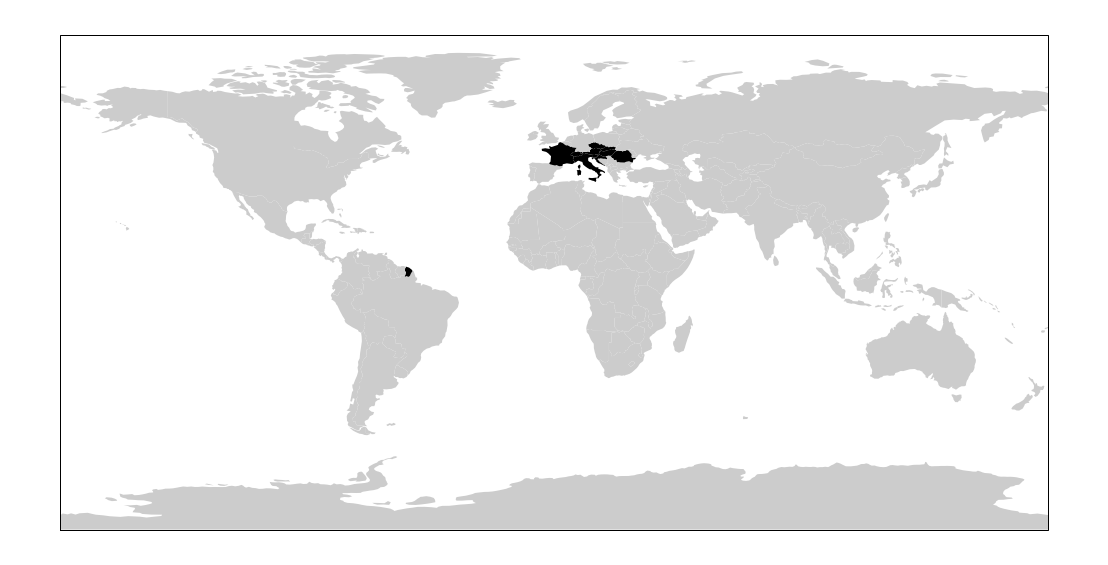

In [7]:
#map the best performing
global_mapping(values = np.array([1]*10), 
               iso = top_performing['iso'].values, 
               rgb = (0,0,0)
              )

We can observe that all currently high scoring environmental conscious countries are located within Europe. This is a first indicator of collective and geographical awareness regarding the necessity of sustainable behaviour. However, the best performing 10 countries are only a part of a initial picture, since observing differing global commonalities is difficult based on numeric values alone.  

We already observed that the median value is not centeralized at a score of 50. Using alpha color values based on numeric values would be skewed towards dense colours and hinder a good oversight of the performance distribution. Additionally, determining a "good score" is difficult as this index is mainly of comparative rather than evaluative nature. This is why we decided to base the alpha values on the performance quantile of a nation. It is important to note that a missing environmental vitality score is colorised in grey.

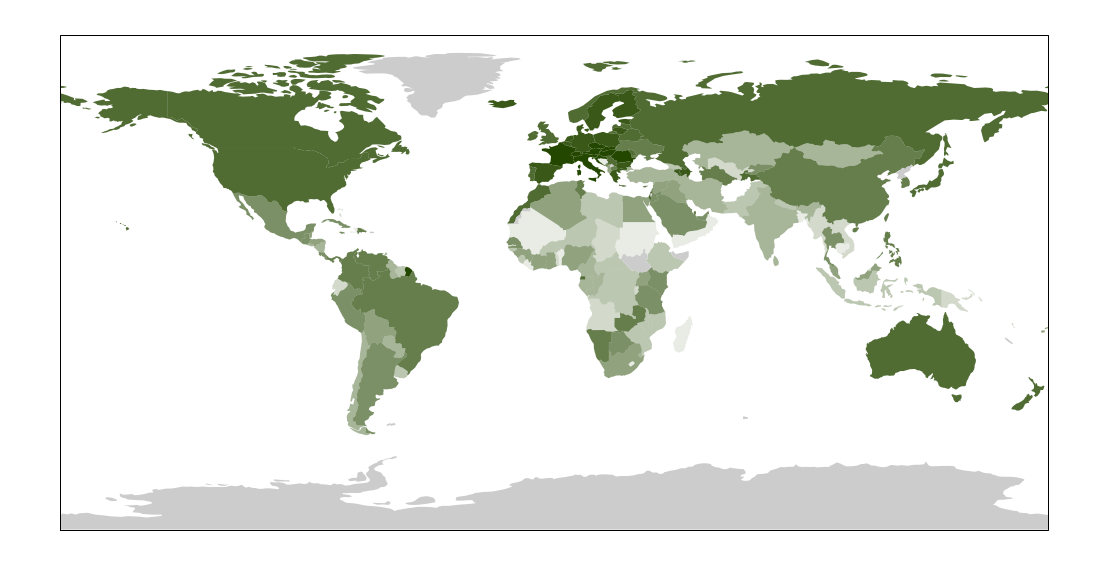

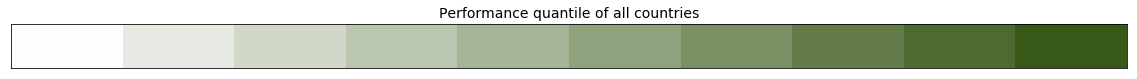

In [8]:
#create data for performance quantile of all countries
ranks = epi_data["EV.2016"].rank()
quantiles = np.array([round(x,1) for x in ranks/max(ranks)])

global_mapping(values = quantiles, 
               iso = epi_data["iso"].values,
               legend = "Performance quantile of all countries")

The resulting figure seems to provide additional evidence for a geographical pattern in environmental conscioiusness. However, this generally superficial visualization is not enough to draw definite conclusions from.
To dive more into commnalities and underlying factors we will perform a factor analysis in the next section.

# 3. Data preprocessing


## 3.1 Data selection
There is a lot of data available that is describing the current state of many system aspects within almost every country on the world. Therefore it is necessary to filter all this data to get a useful subset which gives a general impression of the current state of a country's development. The UN composed a framework that comprehends indicators of sustainable development (UN, 2007). In this report we used these indicators to create a subset of significant indicators describing the development of a country. Unfortunately,  not all indicators of this subset where available in the World Bank Database and/or in the related databases in the WBdata package. Because of the limited timespan of this project, we chose to eliminate the missing indicators in our report. 

However, most of the core indicators of the UN’s framework are present in the selected subset. The core indicators were not present for the UN themes biodiversity, consumption and production, land, natural hazards ,and oceans, seas and coasts. Furthermore, freshwater and trade indicators are scarcely represented in the selected subset. The consequence of these missing values impacts our research as the UN’s framework is not fully implemented, especially indicators regarding land, consumption and production are expected to have commonalities with regard to environmental consciousness. The other missing indicators describe the natural environment in a certain extend, which is already represented in the environmental health indicator. In our conclusion we will revisit the missing indicators to check if our conclusion hint towards their significance. 

**The selected indicators are located in the Selected_Indicators.xlsx file in the sheet Selected. We manually checked if the indicators where present in the wbdata databank and listed the corresponding indicator name on 20th of October. The file is part of the upload.**

In [9]:
indicators = pd.read_excel("Selected_Indicators.xlsx", sheetname = "Selected", index_col = 0)

All indicators provided by the world bank are requested by using the wbdata library. However, most indicators values are not collected and updated uniformly. Only requesting data values of the recent year would risk a significant amount of missing values. Therefore, the most recent available attribute value is requested.  
However, outdated data might induce bias as a comparability with other attribute values might not be given. Thus data values older than 10 years are deemed to be unacceptable and encoded as missing.

In [10]:
#get indicator data
def getIndicatorData(countries, codes, year = 2016, max_year_gap = 10):
    '''
    This function requests the newest indicator value possible for all given indicators and countries
    
    Keyword arguments:
    countries--list like object cointaining all iso3 namings of the countries
    codes--list like object containing all indicator codes
    year--year of the desired value (default = 0)
    max_year_gap--max gap between requested year and latest possible value (default = 10)
    
    '''
    inds = pd.DataFrame(countries, columns = ["iso"])
    data_date = (datetime.datetime(year-max_year_gap, 1,1), datetime.datetime(year, 1, 1))
    #get all relevant indicators

    print("asking for necessary data")
    data = wbdata.get_dataframe(dict(zip(codes, codes)), country = countries, data_date = data_date, keep_levels = True)
    print("received data")
    
    data = data.stack()
    data = data.unstack(1)
    ret = data.iloc[:,0]

    #get the last valid entry if any available
    latest = []
    for ind in data.index:
        last_valid_year = data.loc[ind,str(year-10):].last_valid_index()
        if(last_valid_year is not None):
            latest += [data.loc[ind,last_valid_year]]
        else:
            #if none is available set it as missing
            latest += [None]
            
    ret.iloc[:] = latest
    #now we need our dataframe in a wide format again
    ret = ret.unstack()
    
    #unfortunately this function returns our indices as the full country names (which are not unified)
    #therefore we get the iso values again and rename the indices
    ret.index = [wbdata.search_countries(x, display = False)[0]['id'] for x in ret.index]

    return ret
    
#get all relevant codes as an array
countries = list(epi_data["iso"].values)

#get all available indicators for sustainable development
un_isd = getIndicatorData(countries, indicators.index)

asking for necessary data
received data


In [11]:
#we are now merging the trends into the dataframe to guarantee unity in the coming part of our script
epi_data.index = epi_data["iso"]
final_data = un_isd.assign(EV = epi_data["EV.2016"])

#select everything except countries with NA slope
final_data = final_data[np.logical_not(final_data['EV'].isnull().values)]

The number of countries in our dataset has now decresed by three. This indicates that there is not a single indicator is available for those countires.

In [12]:
#get all countries that are not in the list
NA_countries = [x for x in countries if x not in final_data.index]
NA_countries
#iso3[[x in NA_countries for x in iso3["iso"]]]

['TWN', 'ZAF', 'WSM']

The affected countries are:  
TWN: Taiwan, Province of China   
ZAF: South Africa  
WSM: Samoa   

## 3.2 Missing values
### 3.2.1 Exploring missing values

To minimise missing values proactively we selected the first valid value. In order to ensure validity values older than 10 years have been dismissed as outdated.
This together with potential difficulties in data gathering for certain indicators leads to a risk of remaining gaps in our data.
We first want to quick impression of the severity of missing values in our data. We use a heatplot indicating missing values as a black spot and existing values as white. This allows us to get a feeling for the missing value pattern in both countries and indicators.

In [13]:
def labeled_heatplot(data, xticks = None, yticks = None, **Kwargs):
    '''
    This function is supposed to print a heatplot with labeled axes.
    It uses the index values if the data is in a dataframe format and no other tick values are submitted.
    
    Keyword arguments:
    data--two dimensional data to be visualized
    xticks--ticks for xlabel (default = None)
    yticks--ticks for ylabel (default = None)
    **Kwargs -- Additional keyword arguements for plt.imshow
    
    ''' 
    
    #receive all key word arguments for imshow
    plot = plt.imshow(data, **Kwargs)

    #rename yticks
    if(yticks is not None):
        plt.yticks(list(range(len(yticks))),yticks)
    elif(isinstance(data,pd.DataFrame)):
        plt.yticks(range(len(data.index)),data.index)

    #rename xticks
    if(xticks is not None):
        plt.xticks(list(range(len(xticks))),xticks)
    elif(isinstance(data,pd.DataFrame)):
        plt.xticks(range(len(data.columns)),data.columns)

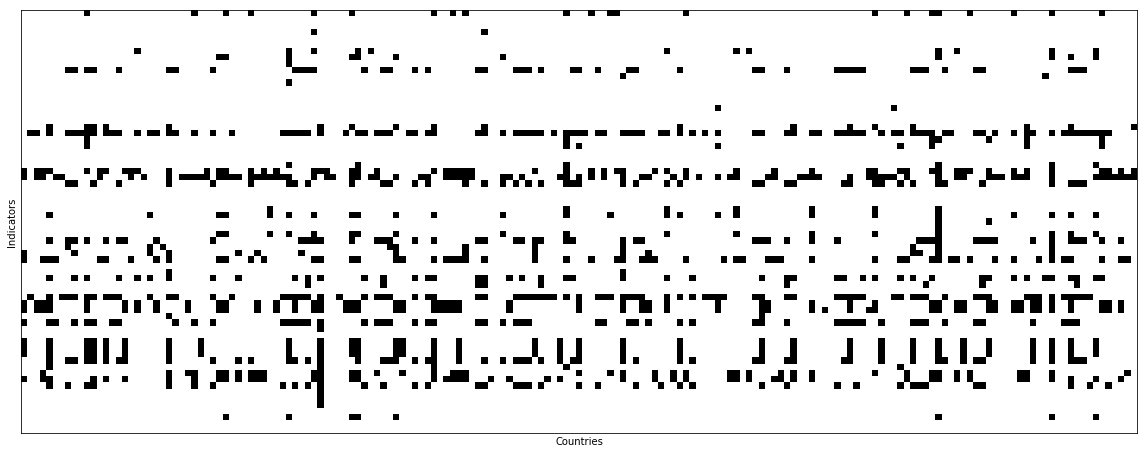

In [14]:
#show number of columns with missing values
#print(len(education_best.dropna(axis = 1).columns))
final_data
plt.rcParams['figure.figsize'] = (20,10)
misval_int = final_data.isnull().astype("int")
#plot the heatmap of missng value transposed so if fits one the screen easily
labeled_heatplot(misval_int.values.T, xticks = "", yticks = "", cmap = "binary")
plt.xlabel("Countries")
plt.ylabel("Indicators")
plt.show()

It gets apparent that we have indicators with a relatively large amount of missing values. While on the other hand, the missing values seem to be distributed over all countries relatively uniformly. This indicates a common agreement of collecting data for a handful of key performance metrics but a lack of agreement some other regards.

There are three main approaches of dealing with missing values in our dataset.  
 1) Remove all indicators with missing values  
 2) Remove all countries with missing values  
 3) Perform sensible value imputation  

Missing values can additionally be distinct in three main patterns:  
 1) Missing completely at random  
 2) Missing at random : Missing values underly observable parameter.  
 3) Missing not at random : Missing values underly unobservable parameter.  

If we can observe missing value patterns or use algorithms that search for a pattern, a sensible imputation might be possible. We already observed that the patterns of missing values in our indicators are more distinct than the patterns of missing values in our countries. Removing all countries with missing values will probably reduce the the sample size to a point where an analysis is not valid anymore. It has also been stated that ignoring indicators because of unavailability might induce selection bias. To observe the possibility of removing attributes lets first get a better overview of the severity of missing values.

In [15]:
#get frequency of missing values per attribute
freq_missing = final_data.isnull().sum()
counts_missing = freq_missing.groupby(freq_missing).count()

#display the missing value counts in a visually pleasing manner
counts_missing_df = pd.DataFrame(counts_missing.values, index = counts_missing.index, columns = ["Freq. of missing values"]).transpose()
counts_missing_df.columns.name = "Nr. of missing values"
pd.set_option('display.max_columns', len(counts_missing_df.columns))
counts_missing_df

Nr. of missing values,0,1,2,5,6,7,8,9,11,12,16,18,22,25,33,40,42,45,46,47,49,51,53,55,56,58,81,87,95
Freq. of missing values,20,7,6,1,1,2,2,1,2,1,1,2,1,1,3,1,1,1,1,1,1,1,1,2,1,2,1,1,1


We can observe that there several indicators with up to 50% of the values missing. Performing a value imputation on those indicators must follow a well reasoned and logical scheme. Imputation on missing values that are not missing at random or that are missing completely at random risks adding noise instead of information. However, removing all indicators with missing values might remove valueable information as well.

An indicator is usefull when it provides additional information. This means data values differ from the existing value pattern in a consistent manner. A first indication of potential information value of an indicator is the correlation with other indicators. A high correlation between itself and other indicators hints redundancy in its implicit knowledge.

We reuse the heatplot function to visualize a correlation matrix of all indicators. We also map the correlation to their state of mising values to observe if a intensive missing value handling is necessary or if most indicators with missing values consist of redundant information anyway.

The correlation between two indicators with missing values is calculated on mutually available instances. It is important to note that every kind of correlation (positive and negative) can be used to explain reconstruct the data values. We therefore map the alpha values of our colorization on the absolute correlation values.

In [16]:
def robust_correlation(data):
    '''
    This function is used to compute a correlation matrix between all rows for data with missing values.
    
    Keyword arguments:
    data--two dimensional datastructure

    '''
    tmp_dat = data.copy()

    ret = []
    #iterate over the rows
    for i,x in enumerate(tmp_dat):
        row = []
        #iterate over all rows again
        for j,y in enumerate(tmp_dat):
            #nan in either x or y
            missing = np.isnan(x) + np.isnan(y)
            
            #get correlation of remaining values
            tmp_x, tmp_y = x[np.logical_not(missing)],y[np.logical_not(missing)]
            if(tmp_x.size == 0 and tmp_y.size == 0):
                row += [0]
            else:
                #if(tmp_x.size == 1):
                #get the correlation coefficient
                row += [np.corrcoef(tmp_x,tmp_y)[0][1]]
                
        ret += [row]
    return np.array(ret)

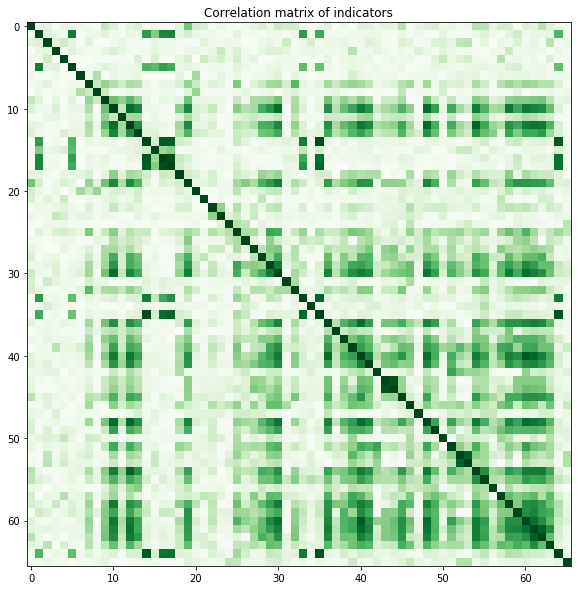

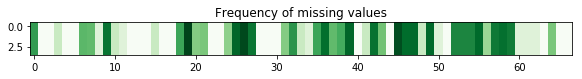

In [17]:
corr_indicators = robust_correlation(final_data.iloc[:,:-1].values.T)

#fig, ax = plt.subplots(2,1, figsize=(15,15))
fig, ax = plt.subplots(1,1, figsize=(10,10))
labeled_heatplot(abs(corr_indicators),  cmap = "Greens")
plt.title("Correlation matrix of indicators")

fig, ax = plt.subplots(1,1, figsize=(10,0.595))
labeled_heatplot(np.log(np.array([[x+1]*4 for x in freq_missing.values]).T), cmap = "Greens")
plt.title("Frequency of missing values")
plt.show()

We can observe that there seems to be no clear distinctive pattern between high correlation and a large amount of missing values. Both highly and slightly correlated features can occur with missing values. Therefore, removing all indicators is not advisable.

### 3.2.2 Handling attributes with a lot of missing values

Indicators with a large number of missing values might have a missing value pattern.
There are multiple reasons why indicators might be missing with a large number. The most straight forward explanation is that values for those indicators are difficult to gather. Those values might be missing at random and thus removing instances with missing values should not induce bias towards our analysis. However, the sheer number of missing values would decrease our sample size significantly. Thus we decide to remove the indicators rather than the instances.

Other explanations could include that this information is sensitive or could depreciate the originating country. Those explanations are both not missing completely at random but are difficult to impute as it is expected that reference values are also sparse.

Lastly zero values could have potentially been documented as missing values. To check for this we plot a list of all indicators with highly frequent missing values.

In [18]:
close_calls = freq_missing[(freq_missing >30)]
large_missing = indicators[[x in close_calls.index for x in indicators.index]].iloc[:,0:1]
large_missing = large_missing.sort_index()
large_missing["missing"]= close_calls.sort_index()
large_missing

,Indicator,missing
ID,,
DT.ODA.ODAT.GN.ZS,Net ODA received (% of GNI),46
EN.POP.SLUM.UR.ZS,Population living in slums (% of urban populat...,95
GB.XPD.RSDV.GD.ZS,Research and development expenditure (% of GDP),58
GC.DOD.TOTL.GD.ZS,"Central government debt, total (% of GDP)",87
IC.FRM.BRIB.ZS,Bribery incidence (% of firms experiencing at ...,45
SE.ADT.LITR.ZS,"Literacy rate, adult total (% of people ages 1...",51
SE.SEC.CUAT.UP.ZS,"Educational attainment, at least completed upp...",58
SH.HIV.INCD.ZS,Incidence of HIV (% of uninfected population a...,47
SH.MLR.INCD.P3,"Incidence of malaria (per 1,000 population at ...",81


We can observe three indicators where the zero frequency explanation seems plausible
- Net ODA received (% of GNI) (DT.ODA.ODAT.GN.ZS)
- Population living in slums (% of urban population) (EN.POP.SLUM.UR.ZS)
- Incidence of malaria (SH.MLR.INCD.P3)

In [19]:
#1) remove all attributes with more than 10 missing values
sel_final_data = final_data.drop(freq_missing[(freq_missing >=10)].index, axis = 1)
print("missing values left %d" % (np.isnan(sel_final_data).sum().sum()))

#2) for false zeros, set the values to 0 and join to the dataframe
false_zero_ind = ['DT.ODA.ODAT.GN.ZS','EN.POP.SLUM.UR.ZS','SH.MLR.INCD.P3']
false_zero_dat = final_data.loc[:,false_zero_ind]
false_zero_dat[false_zero_dat.isnull()] = 0
sel_final_data = sel_final_data.join(false_zero_dat)

missing values left 69


We now performed the zero imputation on all relevant features and removed all other indicators with more than 10 missing values.
All other indicators with more than 10 missing values do not offer a simple imputation possibility. Therefore, we remove them.

### 3.2.3 Handling attributes with infrequent missing values

Attributes with only infrequent missing values offer the possibility imputation by interpolation. Van der Heijden et. al (2006) discovered that performing a complete case analysis often yields to worse results than an analysis with imputed values. The loss of degrees of freedom by estimating their values is an acceptable tradeoff for the gained information of the attribute. We set the maximum number of acceptable missing values to 10. An additional conclusion is that more sophisticated imputation methods taking all attributions into account often are superior to single imputation methods (van der Heijden et. al, 2006).

Unfortunately, the most popular packages in python do not offer more sophisticated value imputation methods. Therefore, we implemented the proposed k-NN imputation algorithm by Gupta, A. (2015). To fulfill the proposed transformation properties of Gupta (2015) all values have been min-max normalized as it historically yields good results (Al Shalabi, 2006). It is important to note that our implementation is only capable of transforming numerical data and not categorical features. 
One potential change to the model might include the usage of the Euclidean distances instead of the Manhattan distance to penalize big outlying values. However, as the effect of this change has not been analysis we decided to stay true to the proposed algorithm.

In [20]:
def KNNImputation(data, k, delta):
    '''
    Perform k-nearest-neighbor imputation for missing values based on:    
    Gupta, A. (2015, April). Overcoming Missing Values In A Random Forest Classifier.
    Retrieved from https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba
    
    Keyword arguments:
    data--two dimensional numpy array or numpy matrix
    k--number of neighbors to take into consideration
    delta--penalty term for each value with missing values. (1 = guaranteed 0 missing values)   

    '''
    
    #normalize values (min max normalization) to guarantee no distance bias through differing value scales
    #get min array
    max_arr = np.array([np.nanmax(data[:,i]) for i,x in enumerate(data[0])])
    #get max array
    min_arr = np.array([np.nanmin(data[:,i]) for i,x in enumerate(data[0])])
    tmp_data = (data-min_arr)/(max_arr-min_arr)
    
    #Create distance matrix according to airbnb
    distance_m = np.zeros((data.shape[0],data.shape[0])) #preallocate for efficiency reasons
    for i,x in enumerate(tmp_data):
        for j,y in enumerate(tmp_data):
            
            #remove missing values from both vectors
            miss = np.isnan(x) + np.isnan(y)
            distance = abs(x[np.logical_not(miss)]-y[np.logical_not(miss)]).sum()
            
            #add times of missing values as delta to it
            distance += (np.isnan(x).sum()*delta + np.isnan(y).sum()*delta)
            distance_m[i,j] = distance
            
    #set diagonal to max value to avoid each instance beeing its own nearest neighbor
    np.fill_diagonal(distance_m,distance_m.max())
            
    #for every missing value, select the k-nearest neighbors
    for i,x in enumerate(tmp_data):
        #for every instance with missing value, perform imputation
        if(np.isnan(x).sum() > 0):
            #get the indices of the k nearest neighbors (min distance values)
            min_distances = distance_m[i].argsort()[:k][::1]
            
            #find the indices of missing values in this instance
            missing_ind = np.argwhere(np.isnan(x))
            
            #perform value imputation with the median value of all k nearest neighbors
            for m in missing_ind:
                tmp_data[i,m[0]] = np.median(tmp_data[min_distances,m[0]])
    
    #unnormalize the values before returning    
    return tmp_data*(max_arr-min_arr)+min_arr

The proposed algorithm is now performed on the current indicator selection. We decided to use the five nearest neighbors in our imputation methodology. This is a frequently used default value in k-NN algorithms and should allow for a robust tradeoff between under- and overfitting.

In [21]:
%time nmv_final_data = KNNImputation(sel_final_data.values,5,1)
nmv_final_data = pd.DataFrame(nmv_final_data,sel_final_data.index,sel_final_data.columns)

#check if we have zero missing values left
print("missing values: %d" % (np.isnan(nmv_final_data).sum().sum()))

CPU times: user 1.02 s, sys: 26.5 ms, total: 1.04 s
Wall time: 3.3 s
missing values: 0


## 4. Exploratory the factor analysis
### 4.1 Identifying valid factors

Now that the data is selected and missing values have been eliminated we can perform the factor analysis.
The goal of this factor analysis is to find latent variables underlying all descriptors to enable an easier summary and distinction between countries. The impact of all found descriptive factors on environmental consciousness is the second part of our analysis 
Similar to the k-NN imputation, we have to perform a normalization before conducting a factor analysis. If we would not do that indicators with a bigger scale would be interpreted as more important in the factor description. Therefore, the factor loadings of all other indicators would be underestimated.

In [22]:
scaler = MinMaxScaler()
factor_train_data = nmv_final_data[nmv_final_data.columns.difference(["EV"])]
nmv_final_data_norm = scaler.fit_transform(factor_train_data.values)
#For the beginning we remove all indicators with missing values
m = FactorAnalysis()
m.fit(nmv_final_data_norm)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

The coherence and descriptive power of a factor is generally explained by the eigenvalues of the factors. All eigenvalues of the factors are visualized in decreasing order.

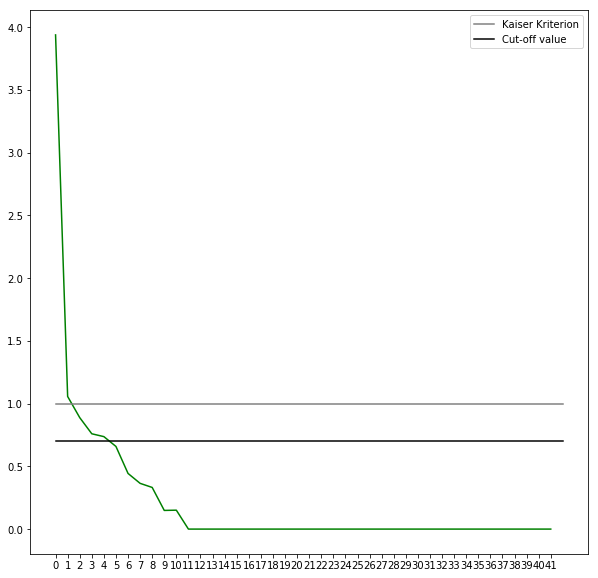

In [23]:
#get the factor eigenvalues
eigenvalues = [x.sum() for x in abs(m.components_)]

#plot the factor eigenvalues
plt.rcParams['figure.figsize'] = (10,10)
plt.xticks(list(range(len(eigenvalues))))
plt.plot(range(len(eigenvalues)), eigenvalues, color = "g")
plt.plot([0, len(eigenvalues)], [1,1], color = "grey", label = "Kaiser Kriterion")
plt.plot([0, len(eigenvalues)], [0.7,0.7], color = "black", label = "Cut-off value")
plt.legend()
plt.show()

The *Kaiser criterion* states as an approximate guideline that factors with an cumulated eigenvalue of lower than 1 do not have explanatory value. As we can observe in the figure above this would lead to a cut-off of all factors except for one. This would reduce the interpretability of our exploratory factor analysis significantly. To determine other potential trends we therefore select a cut-off value of 0.7.

Additionally to the descriptive power of a factor its internal consistency and therefore validity is important. This can be observed by calculating the communalities of all factors.

In [24]:
#get the communalities
communalities = pd.DataFrame((m.components_**2)[:5,:].sum(axis = 1), columns = ["communality value"]).transpose()
communalities.columns.name = "factors"
communalities

factors,0,1,2,3,4
communality value,0.77034,0.056195,0.04069,0.024952,0.030325


Similar to the eigenvalue analysis, communalities indicate that only the first factor allows for a valid interpretation. We keep this in mind for our result discussion and conclusion but continue with our previously selected cut-off value for the eigenvalues of 0,7.

In the next part, we are aiming for interpreting factors as underlying latent variables. To allow for an easier interpretation we rearrange all factor loadings by assumed factor affiliation and sort the values descendingly within each factor. We attribute each indicator to the factor with the highest loading value.
Also, in order to reduce the matrix complexity, we assume that every indicator without at least one factor loading value exceeding 0,2 can be omitted in our interpretation.


In [25]:
nr_selected_factors = 5
factors_loadings = pd.DataFrame(m.components_[:nr_selected_factors].T, index = factor_train_data.columns)
ind_names = factors_loadings.join(indicators["Indicator"])["Indicator"]
factors_loadings.index = ind_names.values

In [26]:
def rearangeFactors(df, thres):
    """
    Rearange the factor loadings for easier interpretability.
    
    Keyword arguments:
    df--dataframe containing factors to be rearanged
    thres--Minimum loading of an indicator on a factor to be considered relevant
    """
    
    #remove indicators with insufficient contribution
    tmp_df = df[abs(df).max(axis = 1) >= thres].copy()
    #tmp_df = df[abs(df).sum(axis = 1) > thres].copy()
    
    #boolean values of positive values
    isneg_matr = (df > 0)
    #code positive values as 1 and negative values as -1
    isneg_matr = ((isneg_matr.astype("int")+1)*2)-3
    
    tmp_df["max_col"] = abs(df).idxmax(axis=1)
    tmp_df["max_col"] = tmp_df["max_col"].astype("int")
    ascending = [True] + [False]*(len(tmp_df.columns)-1)
    
    ret = abs(tmp_df).sort_values(by = [tmp_df.columns[-1]] + list(tmp_df.columns[0:-1]), ascending = ascending).iloc[:,:-1]

    #restoring the original values without changing the sorting order
    for x in ret.index:
        ret.loc[x,:] = ret.loc[x,:]*isneg_matr.loc[x,:] 
       
    ret["Factor"] = abs(df).idxmax(axis=1)
  
    return ret

In [27]:
#sort the remaining ids based on factor allocation
rearanged_factor_loadings = rearangeFactors(factors_loadings, 0.2)
rearanged_factor_loadings

,0,1,2,3,4,Factor
Access to clean fuels and technologies for cooking (% of population),-0.339598,-0.035936,0.009675,0.049101,0.030951,0
Improved sanitation facilities (% of population with access),-0.290538,-0.036138,0.003526,0.015104,0.032132,0
Access to electricity (% of population),-0.282052,-0.020160,0.019052,-0.003292,0.022828,0
Individuals using the Internet (% of population),-0.246801,-0.014203,-0.029363,0.037727,0.005448,0
Population living in slums (% of urban population),0.242096,0.036925,-0.003318,-0.001182,0.000475,0
Renewable energy consumption (% of total final energy consumption),0.229060,0.019929,-0.066589,-0.020297,-0.047899,0
"Life expectancy at birth, total (years)",-0.216848,-0.014404,-0.010934,0.005682,0.000110,0
"Mortality rate, under-5 (per 1,000 live births)",0.210924,0.016355,0.003284,0.009795,0.008085,0
"Fertility rate, total (births per woman)",0.201747,0.007989,0.013765,0.016290,-0.003095,0


We can observe 9 indicators with at least one absolute factor score loading of more than 0,2. Every indicator seems to be allocated to the first factor with no interpretability of the remaining factors. However, the multidimensionality of this allocation towards the first factor makes an unambiguous interpretation difficult. Additionally, none of these factors loading values exceed a value of 0,4 which is widely accepted as minimum importance.
To overcome this problem, we conduct a varimax factor rotation on the resulting loading matrix.

### 4.2 Perform factor rotation

Varimax factor rotation tries to minimise the number of indicators necessary to describe a factor. For that it assumes independence between all factors. The resulting dimensionality reduction of relevant indicators the interpretation of a factor is simplified.

Unfortunately, the varimax rotation is not implemented in the most popular statistical libraries of python. Therefore, we implemented the varimax algorithm ourselves based on Harman (1976). To confirm the correctness of the implementation we compared the output with the implemented varimax function of R. 

In [28]:
def varimax(V, normalize = True, esp = 10e-5):
    '''
    Implementation of the varimax factor rotation based on:
    Harman, H. H. 1976. Modern Factor Analysis, 3rd ed. Chicago: University of Chicago Press
    Results are identical to the varimax(m) function in R.
    
    V--vector matrix to be rotated
    normalize--whether the values should be normalized (default = True)
    esp = Threshold in change for termination (default = 10e-5)
    '''

    n = len(V)
    if(normalize == True):
        #diagonal matrix of communalities (for normalization)
        Hn = np.diag([((V[i]**2).sum())**(-0.5) for i in range(n)])
        H = np.diag([((V[i]**2).sum())**(0.5) for i in range(n)])
        
        #normalize the matrix
        norm_V = np.dot(Hn,V)
        rotated_V = varimaxIteration(norm_V)
        return np.dot(H,rotated_V) #unnormalize final matrix
    else:
        return varimaxIteration(V)
    
#we are only implementing the varimax algorithm
def calcSV(matrix):
    '''
    Calculation of the stoppage value for the matrix rotation
    '''
    n = len(matrix)
    m = len(matrix[0])
    SV = 0
    for i in range(m):
        SV += (n*(matrix[:,i]**4).sum() - (((matrix[:,i]**2).sum())**2)/n**2)
    return SV

def varimaxIteration(V, esp = 10e-5):
    '''
    Recursive inner function for the varimax factor rotation
    '''
    tmp_V = V.copy()
    n = len(V)
 
    #calculate all attribute combinations (fj,fk) where k > j
    switches = [[x,y] for x in range(len(V[0])) for y in range(x,len(V[0])) if x != y]
    
    for x in switches:
        fj = tmp_V[:,x[0]]
        fk = tmp_V[:,x[1]]
        
        u = fj**2 - fk**2
        v = 2*fj*fk
        
        A = u.sum()
        B = v.sum()
        C = np.absolute((u**2-v**2)).sum()
        D = (2*u*v).sum()
        
        X = D-(2*A*B)/n
        Y = C-(A**2-B**2)/n
        P = 0.25*math.atan(X/Y)
        
        if(np.absolute(math.sin(P)) <= (10**(-15))):
            continue
        
        #create rotation matrix
        rotation_m = np.array([[math.cos(P), -math.sin(P)],[math.sin(P),math.cos(P)]])
        #if the numbers get too small numpy will substitute a nan value
        #-> set nan to zero
        tmp_V[:,x] = np.nan_to_num(np.dot(tmp_V[:,x],rotation_m))
        
    if(np.absolute((calcSV(tmp_V) - calcSV(V))) <= (esp)):
        return tmp_V
    else:
        return varimaxIteration(tmp_V)

In [29]:
#Compute the transformed factors...
transformed = varimax(m.components_[:10,:]) #only perform factor rotation for factors with eigenvalue > 0
#... save them in a dataframe ...

rotated_factor_loadings = pd.DataFrame(np.round(transformed[:nr_selected_factors,:], decimals = 3).T,
                                       index = factor_train_data.columns,
                                       columns = range(nr_selected_factors))

#... and rearange them based on factor allocation.
ind_names = rotated_factor_loadings.join(indicators["Indicator"])["Indicator"]
rotated_factor_loadings.index = ind_names.values
rearanged_rotated_factor_loadings = rearangeFactors(rotated_factor_loadings, 0.2)

In [30]:
rearanged_rotated_factor_loadings

,0,1,2,3,4,Factor
Access to clean fuels and technologies for cooking (% of population),-0.853,-0.032,0.003,0.012,0.017,0
Arable land (hectares),0.122,0.234,-0.013,-0.001,-0.005,1
Permanent cropland (% of land area),-0.013,-0.016,0.200,-0.001,0.010,2


### 4.3 Interpretation of factor loadings

The number of indicators has sharply decreased after the factor rotation, with only three indicators remaining distributed over three different factors. Only the first factor has a significant communality value and therefore best is most useful to differentiate between countries. The interpretation of the factor seems simple, as only one indicators remains *"Access to clean fuels and technologies for cooking"*. This indicators feels strange when interpreted without more context, but seems to hint at something related to technology. When we look at the unrotated factor loads, we see that more technology related factors are contributing to the unrotated factor's load. Therefore we think that this factor represents the technological development of a country.  
  
Although without significant factor load, the presence of the indicators *"Permanent cropland"* and *"Arable land"* do remind us of the bias that was introduced after leaving out the core indicators of the UN Land Theme.It might be a coincidence, but we want to further explore the two factors to see if further research into these land related factors might be interesting. The two energy related Consumption and Production indicators did not show up in the (rotated) factors. Therefore, we still cannot conclude anything on the significance of the bias that we introduced during our indicator selection.   
  
# 5. Regression analysis
## 5.1 Conducting regression analysis
So far we only identified one important trait to distinguish behaviour of a society: technological development. After determining this main factor we will now conduct a linear regression analysis to observe whether or not indeed indicates environmental conscious behaviour.

In [31]:
def unpackStatsRet(x):
    keys = ("slope","intercept",'r_value','p_value','stderr') 
    return dict(zip(keys,x))

l = []
for i in range(1,6):
    trans_data = m.transform(nmv_final_data_norm)[:,i-1:i]
    l += [unpackStatsRet(stats.mstats.linregress(trans_data, nmv_final_data.loc[:,"EV"].values))]

In [32]:
l = pd.DataFrame(l)
np.round(l,3)

,intercept,p_value,r_value,slope,stderr
0,62.081,0.000,-0.573,-9.667,1.046
1,62.081,0.474,0.054,0.966,1.347
2,62.081,0.000,-0.394,-8.860,1.560
3,62.081,0.047,0.149,3.558,1.782
4,62.081,0.796,0.020,0.477,1.839


After performing the linear regression on our most important factors we can observe that only two of our factors seemingly are related to environmental health. Every intercept value is returned as 62,081. This results of the varimax assumption of no statistical independency between each factor. While slope and p-values are good indicators for goodness of fit, a visualization often allowes for a easier interpretation of the results.

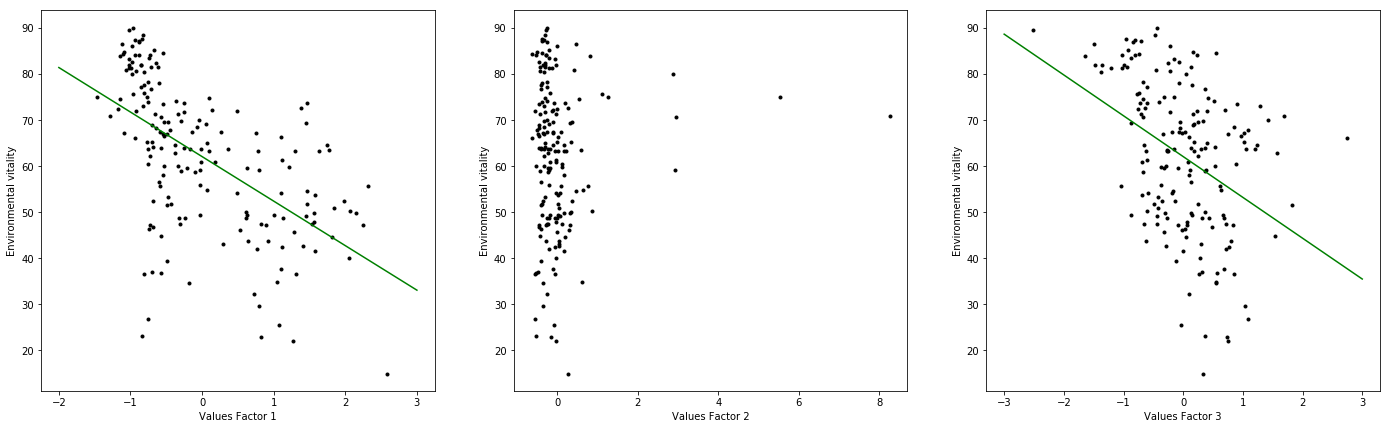

In [33]:
def scatterWithRegr(data, label, regr, xlabels = None, ylabels = None, Kwargs1 = {}, Kwargs2 = {}):
    """
    This function is used to create a scatterplot for a selection of independent variables in regard to their dependent variable.
    If requested this function will also visualize a linear regression line in the scatter plot for a first identification of their dependencies.
    
    Keyword arguments:
    data--independent variables in form of numpy array of arrays
    label--dependent variable in form of a numpy array
    xlabels--list of all xlabels (default = None)
    ylabels--list of all ylabels (default = None)
    Kwargs1--Additional keyword arguements for the scatterplot
    Kwargs2--Additional keyword arguements for the regressionline
    """
    fig, axs = plt.subplots(1,data.shape[1],figsize = (24,7))
    
    for i,ax in enumerate(axs):
        if(xlabels is not None):
            ax.set_xlabel(xlabels[i])
        if(ylabels is not None):
            ax.set_ylabel(ylabels[i])
            
        ax.plot(data[:,i],label,**Kwargs1)
        if(regr[i] is True):
            #set the start and end of regr. line
            x = np.array([math.floor(data[:,i].min()),math.ceil(data[:,i].max())])
            regr_params = stats.mstats.linregress(data[:,i], label)
            ax.plot(x, x*regr_params[0] + regr_params[1], **Kwargs2)
        
        
xlabels = ["Values Factor 1", "Values Factor 2", "Values Factor 3"]
ylabel = ["Environmental vitality"]

scatterWithRegr(m.transform(nmv_final_data_norm)[:,0:3],
                nmv_final_data.loc[:,"EV"].values,
               [True,False,True],
               xlabels = xlabels,
               ylabels = ylabel*3,
               Kwargs1 = {'linestyle':'None','marker':'.', 'color':"black"},
               Kwargs2 = {'color':"g"})

## 5.2 Interpretation of Regression Analysis
The regression analysis shows that factor 1 and factor 3 are significant with reasonable to low r values. When we look at the diagrams, including the linear relations, we see that especially the factor technological development shows a relative good fit. 

There is still a lot of unexplained variance. After observing the scatterplot of the first factor we seemingly can identify certain clusters of deviations. Identifying, naming and performing a separated factor analysis on these "good behaving" countries could be a research question for a follow-up analysis. Due to the limited timespan in which this report had to be composed, a cluster analysis is excluded. However, we see that the EU countries are clustered in the top-left of the diagram and the less developed countries are distributed to the right side of the diagram. The higher the technological development vector is, the lower a country scores on environmental vitality. Therefore, literally interpreting the factor might suggest it represents missing technological development, but depends on the operationalization of the vector value.   
  
We can also see that the second factor shows no regression at all and is rather constant. Conducting further research in this factor is irrelevant. The significance and the plot of the third factor, however, show that there definitely is a relation. Although its communality value is low, it might hint towards a relevance of other land use indicators that might have higher significance.  
 
# 6. Conclusion
Reflecting on the research question, we can conclude that we have found a significant factor that probably shows a positive relation between the degree of technological development and the degree of environmental vitality. 

We can express this relation as:
\begin{align}
y'& = -9.667 x + 62.081 \\
\end{align}

However, the analysis was not perfect as we had to omit several indicators based on availability and to deal with missing values. Collecting this data and rerunning the analysis might yield different results. Furthermore, a cluster analysis is recommended to further research the validity of the identified technological development factor. 

# References 
Al Shalabi, L. (2006). Data Mining: A Preprocessing Engine. Journal of Computer Science, 2(9), 735-739.<Br>
Harman, H. H. (1976). *Modern Factor Analysis* (3rd ed.). Chicago: University of Chicago Press. <Br>
Hsu, A. (2016). 2016 Environmental Performance Index. New Haven, CT: Yale University. Retrieved from www.epi.yale.edu.<Br>
Gupta, A. (2015, April). *Overcoming Missing Values In A Random Forest Classifier*. Retrieved from https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba <Br>
    Davenport, C. (2014). *A Climate Accord Based on Global Peer Pressure*. Retrieved from   https://www.nytimes.com/2014/12/15/world/americas/lima-climate-deal.html <Br>
UN (2007). *Indicators of Sustainable Development: Guidelines and Methodologies*. United Nations: New York, USA <Br>
UN (2015). *Paris Agreement*. United Nations: New York, USA. <Br>
van der Heijden, G. J., Donders, A. R. T., Stijnen, T., & Moons, K. G. (2006). Imputation of missing values is superior to complete case analysis and the missing-indicator method in multivariable diagnostic research: a clinical example. *Journal of clinical epidemiology, 59*(10), 1102-1109.
